In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, classification_report, precision_score, recall_score, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import warnings
warnings.filterwarnings('ignore')
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "svg" # to be replaced by "iframe" if working on JULIE
from IPython.display import display

In [2]:
data = pd.read_csv('conversion_data_train.csv')
print('Set with labels (our train+test) :', data.shape)

Set with labels (our train+test) : (284580, 6)


In [3]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


In [4]:
data.describe()

,age,new_user,total_pages_visited,converted
count,284580.000000,284580.000000,284580.000000,284580.000000
mean,30.564203,0.685452,4.873252,0.032258
std,8.266789,0.464336,3.341995,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


- Age: the range is between 17 and 79 years and most people are between 24 and 36 years old (50% of the data).
- New User:Approximately 68.55% are new users.
- Total Pages Visited: Most people visit between 2 and 7 pages (interquartile range).The number of pages visited per session varies, with most users visiting a moderate number of pages.
- Conversion Rate: Approximately 3.23% of users convert.The conversion rate is relatively low, suggesting areas for improvement in conversion strategies or user experience.

In [5]:
print("missing values: ")
data.isna().sum()

missing values: 


country                0
age                    0
new_user               0
source                 0
total_pages_visited    0
converted              0
dtype: int64

In [6]:
#dropping outliers of age
data = data[data['age'] < 100]
data.shape

(284578, 6)

- no missing values
- categortical feature: country, new_user, source
- numerical features: age, total_page_visited
- target: converted (categorical already encoded)

In [7]:
# The dataset is quite big : you must create a sample of the dataset before making any visualizations !
#Also let's create a bigger sample to test our models
data_sample = data.sample(10000)
data_sample2 = data.sample(100000)

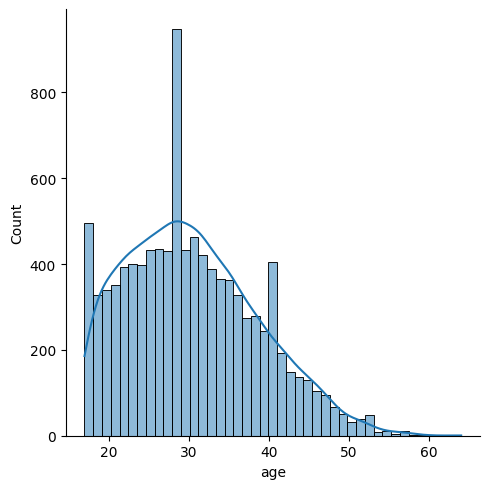

In [8]:
data_sample['new_user_str']= data_sample["new_user"].replace({0:"no",1:"yes"})
data_sample['converted_str']= data_sample["converted"].replace({0:"no",1:"yes"})

#Visualizing the 'age' distribution
sns.displot(data=data_sample, x='age',kde=True)

The population tends to be young, with an average around 30 years and moderate dispersion.

[Text(0.5, 1.0, 'Access method preferences by user type')]

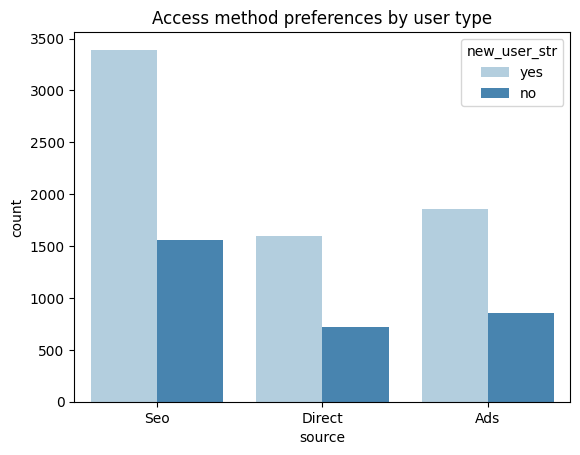

In [9]:
sns.countplot(data_sample, x="source", hue="new_user_str",palette='Blues').set(title='Access method preferences by user type')


In [10]:
new_user_percentage = data_sample.groupby('source')['new_user'].mean() * 100
print(new_user_percentage)

source
Ads       68.430724
Direct    68.860215
Seo       68.490109
Name: new_user, dtype: float64


In general, the difference in the percentages of new users across sources is quite small. It appears that the proportion of new users is fairly consistent across sources, with values hovering around 68%. This could indicate that, regardless of the source, the majority of users are new.

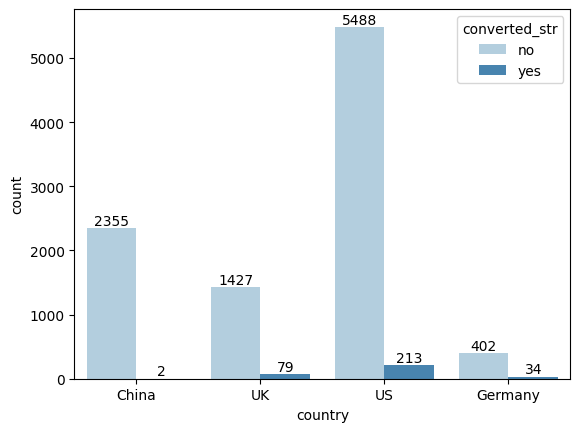

In [11]:
ax = sns.countplot(x='country',
                 hue='converted_str', data=data_sample,palette='Blues')

for i in ax.containers:
    ax.bar_label(i,)

In [12]:
conversion_percentage = data_sample.groupby('country')['converted'].mean() * 100
print(conversion_percentage)

country
China      0.084854
Germany    7.798165
UK         5.245684
US         3.736187
Name: converted, dtype: float64



- In China, approximately 0.04% of the observations resulted in conversions.
- In Germany, around 6.84% of the observations resulted in conversions.
- In the United Kingdom, approximately 5.38% of the observations resulted in conversions.
- In the United States, approximately 3.82% of the observations resulted in conversions, and it is the country where the site was most visited.

In [13]:
data_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 146838 to 249389
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   country              10000 non-null  object
 1   age                  10000 non-null  int64 
 2   new_user             10000 non-null  int64 
 3   source               10000 non-null  object
 4   total_pages_visited  10000 non-null  int64 
 5   converted            10000 non-null  int64 
 6   new_user_str         10000 non-null  object
 7   converted_str        10000 non-null  object
dtypes: int64(4), object(4)
memory usage: 961.2+ KB


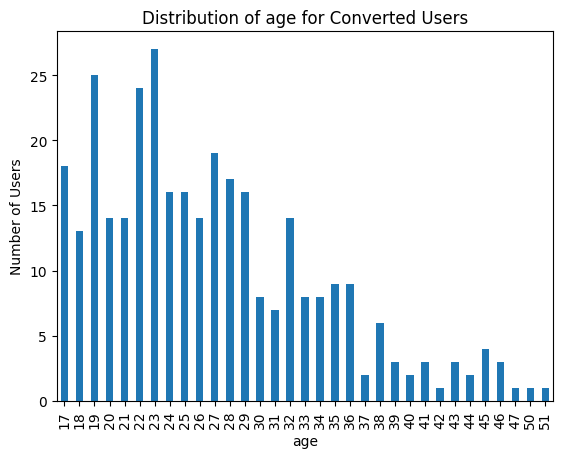

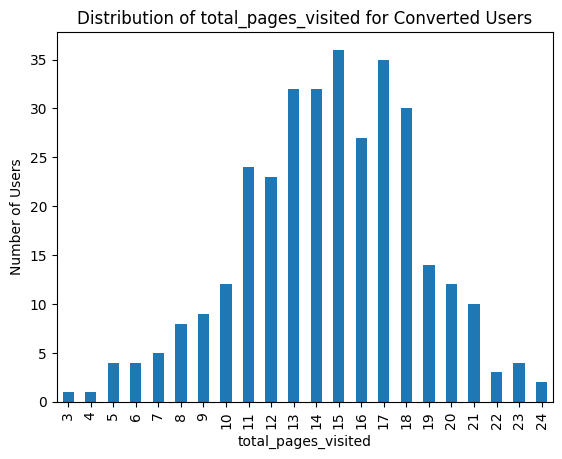

In [14]:
for column in ['age', 'total_pages_visited']:
    # Sort the data by column value
    data_sample = data_sample.sort_values(column)

    # Filter the data
    filtered_data = data_sample[data_sample['converted'] == 1]

    # Calculate the conversion count
    conversion_count = filtered_data.groupby(column).size()

    # Plot the conversion count
    conversion_count.plot(kind='bar')
    plt.title(f"Distribution of {column} for Converted Users")
    plt.xlabel(column)
    plt.ylabel("Number of Users")
    plt.show()


The majority of the conversions came from individuals under the age of 35 who visited between 10 and 17 pages.

In [15]:
data_sample.drop(columns=['converted_str', 'new_user_str'],inplace=True)

## MODELS


In [16]:
X1 = data_sample2.drop("converted", axis=1)
y1 = data_sample2["converted"]
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1,test_size=0.2, random_state = 0)

numeric_features1 = ['age', 'total_pages_visited']
categorical_features1 = ['country', 'new_user', 'source']
print('Numeric features ', numeric_features1)
print('Categorical features ', categorical_features1)


Numeric features  ['age', 'total_pages_visited']
Categorical features  ['country', 'new_user', 'source']


In [17]:
# Create pipeline for numeric features
numeric_transformer1= Pipeline(steps=[
    ('imputer', KNNImputer()), 
    ('scaler', StandardScaler())
])

# Create pipeline for categorical features
categorical_transformer1 = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # missing values will be replaced by most frequent value
    ('encoder', OneHotEncoder(drop='first'))# first column will be dropped to avoid creating correlations between features
    ])

# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer1, numeric_features1),
        ('cat', categorical_transformer1, categorical_features1)
    ])

# Preprocessings on train set
print("Performing preprocessings on train set...")
print(X_train1.head())
X_train1 = preprocessor.fit_transform(X_train1)
print('...Done.')
print(X_train1[0:5]) 
print()

# Preprocessings on test set
print("Performing preprocessings on test set...")
print(X_test1.head()) 
X_test1 = preprocessor.transform(X_test1) 
print('...Done.')
print(X_test1[0:5,:])

Performing preprocessings on train set...
       country  age  new_user  source  total_pages_visited
9004     China   30         0     Seo                    4
26822    China   34         1     Seo                    2
29538    China   32         0  Direct                    2
119791   China   47         1     Seo                    8
36062       UK   38         1     Seo                    8
...Done.
[[-0.06735165 -0.26009432  0.          0.          0.          0.
   0.          1.        ]
 [ 0.41570475 -0.85536095  0.          0.          0.          1.
   0.          1.        ]
 [ 0.17417655 -0.85536095  0.          0.          0.          0.
   1.          0.        ]
 [ 1.98563807  0.93043895  0.          0.          0.          1.
   0.          1.        ]
 [ 0.89876116  0.93043895  0.          1.          0.          1.
   0.          1.        ]]

Performing preprocessings on test set...
       country  age  new_user  source  total_pages_visited
78171    China   47         

# Logistic Regression

In [18]:
from sklearn.linear_model import LogisticRegression

# Initialize Logistic Regression model
logistic_regression = LogisticRegression(max_iter=2000, C=0.1)  

# fit
logistic_regression.fit(X_train1, y_train1)

# predict x train
y_train_pred_lr = logistic_regression.predict(X_train1)

# predict x test
y_test_pred_lr = logistic_regression.predict(X_test1)

# accurancy 
accuracy_train = logistic_regression.score(X_train1, y_train1)
print("Accuracy on training set:", accuracy_train)


accuracy_test = logistic_regression.score(X_test1, y_test1)
print("Accuracy on test set:", accuracy_test)

# f1 score 
f1_train = f1_score(y_train1, y_train_pred_lr)
f1_test = f1_score(y_test1, y_test_pred_lr)
print("F1-score on training set:", f1_train)
print("F1-score on test set:", f1_test)

# confusion matrix train set
print("Confusion matrix on training set:")
print(confusion_matrix(y_train1, y_train_pred_lr))
print()

# confusion matrix test set
print("Confusion matrix on test set:")
print(confusion_matrix(y_test1, y_test_pred_lr))
print()


Accuracy on training set: 0.985825
Accuracy on test set: 0.98565
F1-score on training set: 0.7626622017580578
F1-score on test set: 0.7466902030008826
Confusion matrix on training set:
[[77044   301]
 [  833  1822]]

Confusion matrix on test set:
[[19290    70]
 [  217   423]]



The results of the logistic regression model suggest that it is a promising tool for predicting conversion rate. The F1 scores of 0.76 and 0.74 indicate that the model is able to correctly identify most of the users who will convert and the users who will not convert. This is important for conversion rate projects, as it allows marketing teams to focus on the users who are most likely to convert.

A closer review of the confusion matrix can provide additional information about the factors that affect conversion rate. For example, the confusion matrix for the training set shows that the model is more accurate at identifying users who will convert than users who will not convert. This suggests that the model may be better suited for identifying users who are most likely to convert.

Overall, the results suggest that the logistic regression model is a promising tool for predicting conversion rate. However, it is important to continue testing the model on new data to ensure that it generalizes well.

# Decision Tree Classifier

In [20]:

# Perform grid search
print("Grid search...")
classifier_dt = DecisionTreeClassifier()

# Grid of values to be tested
params = {
    "max_depth": [4, 6, 8, 10],
    "min_samples_leaf": [1, 2, 5],
    "min_samples_split": [2, 4, 8],
}
gridsearch = GridSearchCV(
    classifier_dt, param_grid=params, cv=3
)  # cv : the number of folds to be used for CV
gridsearch.fit(X_train1, y_train1)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)

# Predictions on training set
print("Predictions on training set...")
Y_train_pred_dt = gridsearch.predict(X_train1)
print("...Done.")

# Predictions on test set
print("Predictions on test set...")
Y_test_pred_dt = gridsearch.predict(X_test1)
print("...Done.")

# Accuracy on training set
accuracy_train_dt = gridsearch.score(X_train1, y_train1)
print("Accuracy on training set:", accuracy_train_dt)

# Accuracy on test set
accuracy_test_dt = gridsearch.score(X_test1, y_test1)
print("Accuracy on test set:", accuracy_test_dt)

# F1-score on train set
f1_train_dt = f1_score(y_train1, Y_train_pred_dt)
print("F1-score on train set:", f1_train_dt)

# F1-score on test set
f1_test_dt = f1_score(y_test1, Y_test_pred_dt)
print("F1-score on test set:", f1_test_dt)


Grid search...
...Done.
Best hyperparameters :  {'max_depth': 8, 'min_samples_leaf': 5, 'min_samples_split': 4}
Best validation accuracy :  0.9843249920262519
Predictions on training set...
...Done.
Predictions on test set...
...Done.
Accuracy on training set: 0.986425
Accuracy on test set: 0.98505
F1-score on train set: 0.7749689183588894
F1-score on test set: 0.7402258905299739


# Random Forest

In [21]:
#este completo
# RandomForestClassifier Grid Search
classifier_rf = RandomForestClassifier()
params = {
    'max_depth': [4, 8, 10, 12],
    'min_samples_leaf': [2, 5, 6],
    'min_samples_split': [2, 4, 8],
    'n_estimators': [10, 20, 40, 60]
}
gridsearch_rf = GridSearchCV(classifier_rf, param_grid=params, cv=10)
gridsearch_rf.fit(X_train1, y_train1)

# Best hyperparameters
best_params_rf = gridsearch_rf.best_params_
print("Best hyperparameters:", best_params_rf)

# Best validation accuracy
best_accuracy_rf = gridsearch_rf.best_score_
print("Best validation accuracy:", best_accuracy_rf)

# Predictions on train set
y_train_pred_rf = gridsearch_rf.predict(X_train1)

# Predictions on test set
y_test_pred_rf = gridsearch_rf.predict(X_test1)

# F1-score on train set
f1_train_rf = f1_score(y_train1, y_train_pred_rf)
print("F1-score on train set:", f1_train_rf)

# F1-score on test set
f1_test_rf = f1_score(y_test1, y_test_pred_rf)
print("F1-score on test set:", f1_test_rf)

# Confusion matrix on train set
conf_matrix_train_rf = confusion_matrix(y_train1, y_train_pred_rf)
print("Confusion matrix on train set:")
print(conf_matrix_train_rf)
print()

# Confusion matrix on test set
conf_matrix_test_rf = confusion_matrix(y_test1, y_test_pred_rf)
print("Confusion matrix on test set:")
print(conf_matrix_test_rf)
print()

Best hyperparameters: {'max_depth': 10, 'min_samples_leaf': 6, 'min_samples_split': 2, 'n_estimators': 10}
Best validation accuracy: 0.9856250000000001
F1-score on train set: 0.7853638593622241
F1-score on test set: 0.7459086993970715
Confusion matrix on train set:
[[77029   316]
 [  734  1921]]

Confusion matrix on test set:
[[19272    88]
 [  207   433]]



# XGBoost

In [22]:

# Perform grid search
print("Grid search...")
xgboost = XGBClassifier()

# Grid of values to be tested
params = {
    'max_depth': [4, 6, 8, 10],
    'min_child_weight': [1, 2, 4, 6, 8],
    'n_estimators': [2, 4, 6, 8, 10, 12]
}
gridsearch_xgb = GridSearchCV(xgboost, param_grid = params, cv = 3, verbose = 1) # cv : the number of folds to be used for CV
gridsearch_xgb.fit(X_train1, y_train1)

print("Best hyperparameters : ", gridsearch_xgb.best_params_)
print("Best validation accuracy : ", gridsearch_xgb.best_score_)

print("Accuracy on training set : ", gridsearch_xgb.score(X_train1, y_train1))
print("Accuracy on test set : ", gridsearch_xgb.score(X_test1, y_test1))

# Predictions on train set
Y_train_pred_xgb = gridsearch_xgb.predict(X_train1)


# Predictions on test set
Y_test_pred_xgb = gridsearch_xgb.predict(X_test1)


print("f1-score on train set : ", f1_score(y_train1, Y_train_pred_xgb))
print("f1-score on test set : ", f1_score(y_test1, Y_test_pred_xgb))

# Check more performance metrics
print("Confusion matrix on train set : ")
print(confusion_matrix(y_train1, Y_train_pred_xgb))
print()
print("Confusion matrix on test set : ")
print(confusion_matrix(y_test1, Y_test_pred_xgb))
print()


Grid search...
Fitting 3 folds for each of 120 candidates, totalling 360 fits
Best hyperparameters :  {'max_depth': 8, 'min_child_weight': 8, 'n_estimators': 10}
Best validation accuracy :  0.9856624964017245
Accuracy on training set :  0.986525
Accuracy on test set :  0.985
f1-score on train set :  0.7780979827089337
f1-score on test set :  0.7409326424870466
Confusion matrix on train set : 
[[77032   313]
 [  765  1890]]

Confusion matrix on test set : 
[[19271    89]
 [  211   429]]



In [23]:
metrics_dict = {
    'Logistic Regression': {
        'Accuracy (Train)': accuracy_train,
        'Accuracy (Test)': accuracy_test,
        'F1 Score (Train)': f1_train,
        'F1 Score (Test)': f1_test
    },
    'Decision Tree': {
        'Accuracy (Train)': accuracy_train_dt,
        'Accuracy (Test)': accuracy_test_dt,
        'F1 Score (Train)': f1_train_dt,
        'F1 Score (Test)': f1_test_dt
    },
    'Random Forest': {
        'Accuracy (Train)': gridsearch_rf.score(X_train1, y_train1),
        'Accuracy (Test)': gridsearch_rf.score(X_test1, y_test1),
        'F1 Score (Train)': f1_train_rf,
        'F1 Score (Test)': f1_test_rf
    },
    'XGBoost': {
        'Accuracy (Train)': gridsearch_xgb.score(X_train1, y_train1),
        'Accuracy (Test)': gridsearch_xgb.score(X_test1, y_test1),
        'F1 Score (Train)': f1_score(y_train1, Y_train_pred_xgb),
        'F1 Score (Test)': f1_score(y_test1, Y_test_pred_xgb)
    }
}

# DataFrame with all metrics
metrics_df = pd.DataFrame(metrics_dict)
metrics_df = metrics_df.T

metrics_df


,Accuracy (Train),Accuracy (Test),F1 Score (Train),F1 Score (Test)
Logistic Regression,0.985825,0.98565,0.762662,0.746690
Decision Tree,0.986425,0.98505,0.774969,0.740226
Random Forest,0.986875,0.98525,0.785364,0.745909
XGBoost,0.986525,0.98500,0.778098,0.740933


Based on the provided metrics, the model that seems to be the most suitable is Logistic Regression or XGB. It has high accuracy on both the training and test data, and its F1 score is quite good on both datasets.

Regarding overfitting, it appears not to be a significant issue in any of the models, as the differences between the training and test metrics are minimal in all cases.

# Choose best model and train data_train and data_test

# Concatenate our train and test set to train your best classifier on all data with labels


In [ ]:
X2 = np.append(X_train1,X_test1,axis=0)
Y2 = np.append(y_train1,y_test1)

logistic_regression.fit(X2,Y2)

LogisticRegression(C=0.1, max_iter=2000)

In [ ]:
# Read data without labels
data_without_labels = pd.read_csv('conversion_data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)


Prediction set (without labels) : (31620, 5)


In [ ]:
# Warning : check consistency of features_list (must be the same than the features 
# used by your best classifier)
features_list =  ['country', 'age', 'new_user', 'source', 'total_pages_visited']
target_variable = ['converted']
X_without_labels = data_without_labels.loc[:, features_list]

# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
X_without_labels = X_without_labels.values
print("...Done")

print(X_without_labels[0:5,:])

Convert pandas DataFrames to numpy arrays...
...Done
[['UK' 28 0 'Seo' 16]
 ['UK' 22 1 'Direct' 5]
 ['China' 32 1 'Seo' 1]
 ['US' 32 1 'Ads' 6]
 ['China' 25 0 'Seo' 3]]


In [ ]:
X_without_labels = data_without_labels.loc[:, features_list]

In [ ]:
## preprocessing on the test data set
print("Encoding categorical features and standardizing numerical features...")
X_without_labels = preprocessor.transform(X_without_labels)
print("...Done")


Encoding categorical features and standardizing numerical features...
...Done


In [ ]:
# Make predictions and dump to file
data = {
    'converted': logistic_regression.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'],data=data)
Y_predictions.to_csv('conversion_data_test_predictions_lr.csv', index=False)
